# MOUNT DRIVE

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# EXTRACT ZIP DATASET

In [15]:
import zipfile, os, shutil

zip_path = "/content/drive/MyDrive/train_converted.zip"   # <-- dataset kamu
extract_dir = "/content/dataset_original"

if os.path.exists(extract_dir):
    shutil.rmtree(extract_dir)
os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Dataset berhasil diekstrak ke:", extract_dir)

Dataset berhasil diekstrak ke: /content/dataset_original


# SPLIT DATA + AUGMENTASI (PER KELAS)

In [16]:
import random
from PIL import Image, ImageEnhance, ImageFilter
import numpy as np

train_dir = "/content/dataset/train"
val_dir = "/content/dataset/val"

shutil.rmtree("/content/dataset", ignore_errors=True)
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

def augment_image(img):
    """Melakukan augmentasi ringan."""
    aug = img.copy()

    # Rotasi kecil
    aug = aug.rotate(random.randint(-10, 10))

    # Brightness
    enhancer = ImageEnhance.Brightness(aug)
    aug = enhancer.enhance(random.uniform(0.7, 1.3))

    # Contrast
    enhancer = ImageEnhance.Contrast(aug)
    aug = enhancer.enhance(random.uniform(0.7, 1.3))

    return aug

class_folders = sorted(os.listdir(extract_dir))
print("Jumlah kelas:", len(class_folders))

target_images = 40  # <-- setiap kelas ingin dibuat 40 gambar augmented

for cls in class_folders:
    cls_path = os.path.join(extract_dir, cls)
    if not os.path.isdir(cls_path):
        continue

    images = [f for f in os.listdir(cls_path) if f.lower().endswith((".jpg",".jpeg",".png",".webp",".bmp"))]

    if len(images) < 1:
        print("SKIP:", cls, "tidak punya gambar.")
        continue

    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cls), exist_ok=True)

    # ====== COPY 1 GAMBAR KE VALIDASI ======
    val_img = images[0]
    shutil.copy(os.path.join(cls_path, val_img), os.path.join(val_dir, cls, val_img))

    # ====== AUGMENT UNTUK TRAIN ======
    for idx in range(target_images):
        base_img = random.choice(images)
        img = Image.open(os.path.join(cls_path, base_img)).convert("RGB")

        # augment
        img_aug = augment_image(img)

        save_path = os.path.join(train_dir, cls, f"{cls}_aug_{idx}.jpg")
        img_aug.save(save_path)

print("Augmentasi selesai! Semua kelas memiliki 40 gambar train.")

Jumlah kelas: 70
Augmentasi selesai! Semua kelas memiliki 40 gambar train.


# DATASET PIPELINE

In [17]:
import tensorflow as tf

img_size = (224, 224)
batch_size = 16

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode="categorical",
    shuffle=True
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode="categorical",
    shuffle=False
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Total kelas:", num_classes)

Found 2800 files belonging to 70 classes.
Found 70 files belonging to 70 classes.
Total kelas: 70


# BANGUN MODEL MOBILENETV2

In [18]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

base = MobileNetV2(input_shape=(224,224,3), include_top=False, weights="imagenet")
base.trainable = False

x = GlobalAveragePooling2D()(base.output)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation="softmax")(x)

model = Model(inputs=base.input, outputs=output)

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,347,654 (8.96 MB)

 Trainable params: 89,670 (350.27 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

# TRAINING MODEL

In [19]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=7
)

Epoch 1/7
175/175 ━━━━━━━━━━━━━━━━━━━━ 230s 1s/step - accuracy: 0.1300 - loss: 4.1274 - val_accuracy: 0.7286 - val_loss: 1.7009
Epoch 2/7
175/175 ━━━━━━━━━━━━━━━━━━━━ 226s 1s/step - accuracy: 0.6576 - loss: 1.5816 - val_accuracy: 0.9000 - val_loss: 0.9286
Epoch 3/7
175/175 ━━━━━━━━━━━━━━━━━━━━ 215s 1s/step - accuracy: 0.8173 - loss: 0.8953 - val_accuracy: 0.9571 - val_loss: 0.5976
Epoch 4/7
175/175 ━━━━━━━━━━━━━━━━━━━━ 261s 1s/step - accuracy: 0.8873 - loss: 0.6099 - val_accuracy: 0.9571 - val_loss: 0.4070
Epoch 5/7
175/175 ━━━━━━━━━━━━━━━━━━━━ 227s 1s/step - accuracy: 0.9280 - loss: 0.4454 - val_accuracy: 0.9857 - val_loss: 0.2976
Epoch 6/7
175/175 ━━━━━━━━━━━━━━━━━━━━ 260s 1s/step - accuracy: 0.9571 - loss: 0.3278 - val_accuracy: 0.9714 - val_loss: 0.2395
Epoch 7/7
175/175 ━━━━━━━━━━━━━━━━━━━━ 235s 1s/step - accuracy: 0.9756 - loss: 0.2594 - val_accuracy: 0.9857 - val_loss: 0.1979


# EVALUASI MODEL

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

Classification Report:
                                 precision    recall  f1-score   support

             Nasya Aulia Efendi       1.00      1.00      1.00         1
           Abraham Ganda Napitu       1.00      1.00      1.00         1
       Abu Bakar Siddiq Siregar       1.00      1.00      1.00         1
             Ahmad Faqih Hasani       1.00      1.00      1.00         1
                   Aldi Sanjaya       1.00      1.00      1.00         1
                        Alfajar       1.00      1.00      1.00         1
            Alief Fathur Rahman       1.00      1.00      1.00         1
 Arkan Hariz Chandrawinata Liem       1.00      1.00      1.00         1
               Bayu Ega Ferdana       1.00      1.00      1.00         1
          Bayu Prameswara Haris       1.00      1.00      1

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


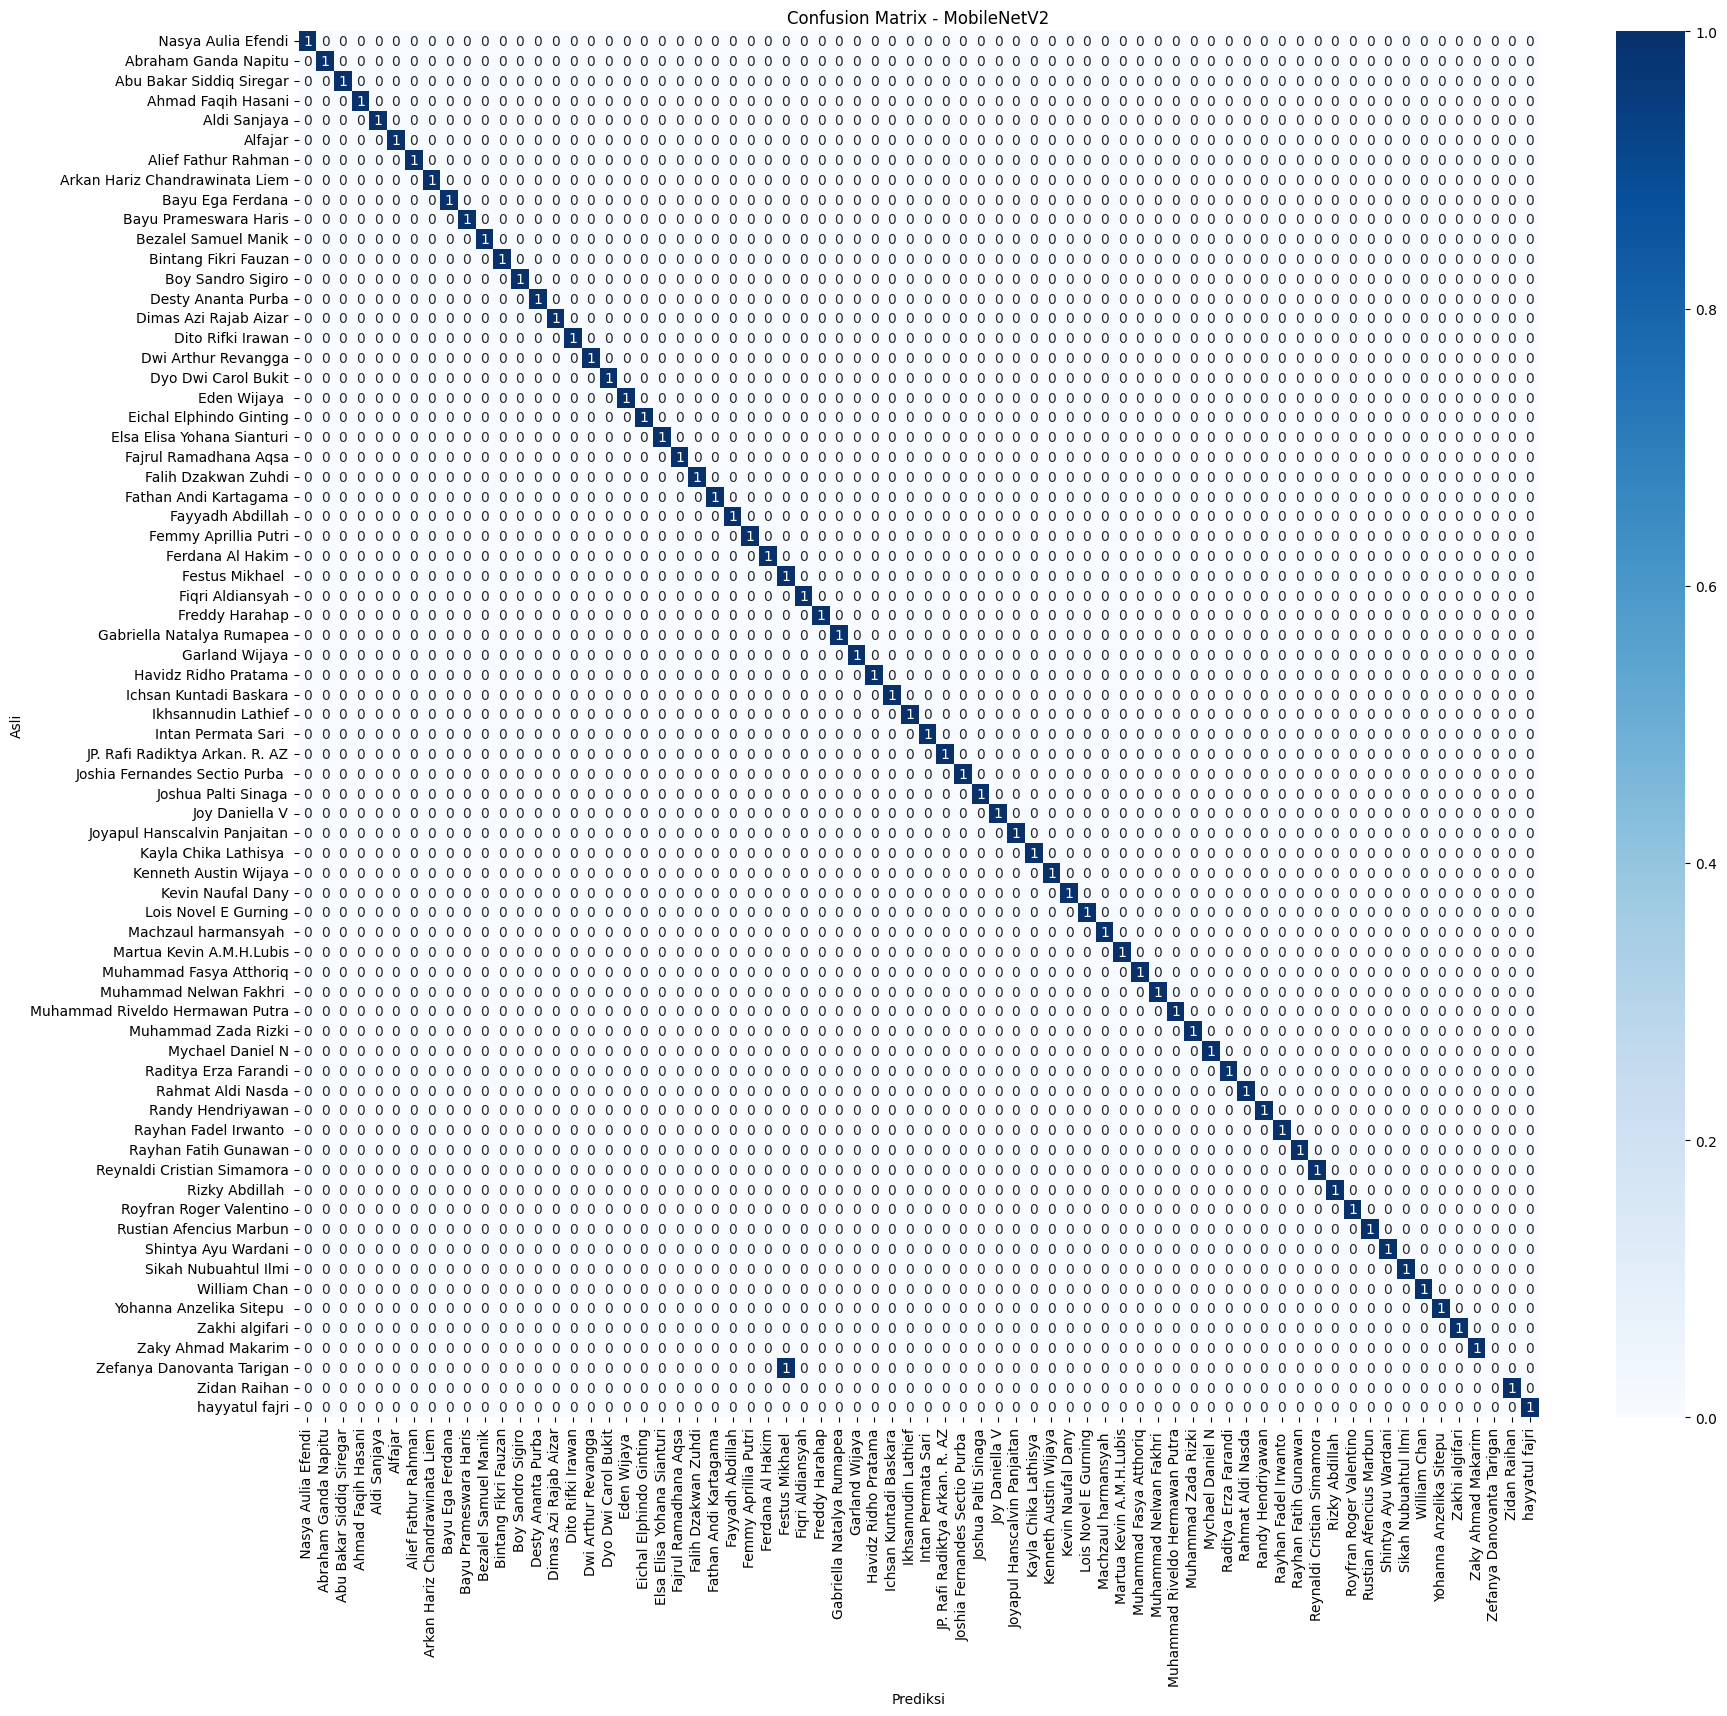

In [20]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(20, 18))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - MobileNetV2")
plt.xlabel("Prediksi")
plt.ylabel("Asli")
plt.show()

In [27]:
model.export("mobilenetv2_savedmodel")

Saved artifact at 'mobilenetv2_savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_314')
Output Type:
  TensorSpec(shape=(None, 70), dtype=tf.float32, name=None)
Captures:
  135119242030032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135119242032144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135119242029648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135119242031952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135119242032336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135119242030608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135118663134352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135118663135888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135119242030416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135119242030800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135

In [28]:
import shutil
shutil.make_archive("mobilenetv2_savedmodel", "zip", "mobilenetv2_savedmodel")

'/content/mobilenetv2_savedmodel.zip'

In [30]:
from google.colab import files
files.download("mobilenetv2_savedmodel.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>